In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,DepthwiseConv2D,Input,Add,Input,Activation,GlobalAveragePooling2D,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset= '/content/drive/MyDrive/Plant_Disease'
print(os.listdir(dataset))
train_dir = os.path.join(dataset, 'Apple_bg_removed')
valid_dir = os.path.join(dataset, 'Apple_valid_bg_removed')
#test_dir = os.path.join(dataset, 'Apple_Testing_bg_removed')

['VGG-19.ipynb', 'Apple_valid', 'training_history.json', 'Hybrid-Vgg-19-DepthRes.ipynb', 'training_history_4096.json', 'training_history_2048.json', 'File-uploads.ipynb', 'Testing', 'training_history_512.json', 'Apple_2', 'Apple_3', 'VGG-19-Depthwise.ipynb', 'Apple', 'training_history_512_2.json', 'training_history_512_2_1.json', 'u2net_portrait.pth', 'bg-removed', 'Apple_bg_removed', 'Apple_valid_bg_removed', 'training_history_64.json', 'Apple_Testing', 'Apple_Testing_bg_removed', 'Testing_bg_removed', 'Testing_apple', 'Testing_bg_removed_2', 'Apple_Disease_4classes_64.json', 'Apple_Disease_4classes_64.keras', 'Apple_Disease_4classes_64_weights.weights.h5', 'Testing test set.ipynb']


In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
valid_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

test_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7039 files belonging to 4 classes.
Using 5632 files for training.
Found 1953 files belonging to 4 classes.
Found 7039 files belonging to 4 classes.
Using 1407 files for validation.


In [ ]:
from collections import Counter
def count_classes(dataset, class_names):
    class_counts = Counter()
    for images, labels in dataset:
        label_indices = np.argmax(labels.numpy(), axis=1)
        for label_idx in label_indices:
            class_counts[class_names[label_idx]] += 1
    return class_counts

class_names = training_set.class_names

In [ ]:
train_counts = count_classes(training_set, class_names)
valid_counts = count_classes(valid_set, class_names)
test_counts = count_classes(test_set,class_names)

print("Training Set:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nValidation Set:")
for class_name, count in valid_counts.items():
    print(f"{class_name}: {count}")

print("\nTest Set:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

Training Set:
Apple___Cedar_apple_rust: 1411
Apple___healthy: 1414
Apple___Apple_scab: 1424
Apple___Black_rot: 1383

Validation Set:
Apple___Black_rot: 497
Apple___healthy: 502
Apple___Cedar_apple_rust: 450
Apple___Apple_scab: 504

Test Set:
Apple___Black_rot: 376
Apple___Apple_scab: 336
Apple___Cedar_apple_rust: 349
Apple___healthy: 346


In [ ]:
def residual_block(x, filters):
    shortcut = x
    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(0.001))(shortcut)

    x = DepthwiseConv2D((3, 3), padding='same', depthwise_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = DepthwiseConv2D((3, 3), padding='same', depthwise_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Add()([x, shortcut])

    return x

In [ ]:
def hybrid_vgg19(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Block 1
    x = DepthwiseConv2D((3, 3), padding='same', depthwise_regularizer=l2(0.001))(inputs)
    x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', depthwise_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 2
    x = residual_block(x, filters=128)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 3
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 4
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 5
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model_1 = Model(inputs=inputs, outputs=outputs)

    return model_1

In [ ]:
model=hybrid_vgg19(input_shape=(224, 224, 3), num_classes=4)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
training_history = model.fit(x=training_set,validation_data=valid_set,epochs=200,callbacks=[early_stopping])

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.5683 - loss: 27.4608 - val_accuracy: 0.8551 - val_loss: 9.1153
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8408 - loss: 8.2714 - val_accuracy: 0.8546 - val_loss: 6.3750
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9034 - loss: 5.8445 - val_accuracy: 0.9447 - val_loss: 4.7850
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9247 - loss: 4.5923 - val_accuracy: 0.8536 - val_loss: 4.2644
Epoch 5/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9303 - loss: 3.8881 - val_accuracy: 0.9365 - val_loss: 3.4844
Epoch 6/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9212 - loss: 3.4211 - val_accuracy: 0.9053 - val_loss: 3.1991
Epoch 7/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9288 - loss: 3.0544 - val_accuracy: 0.9519 - val_loss: 2.7642
Epoch 8/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9492 - loss: 2

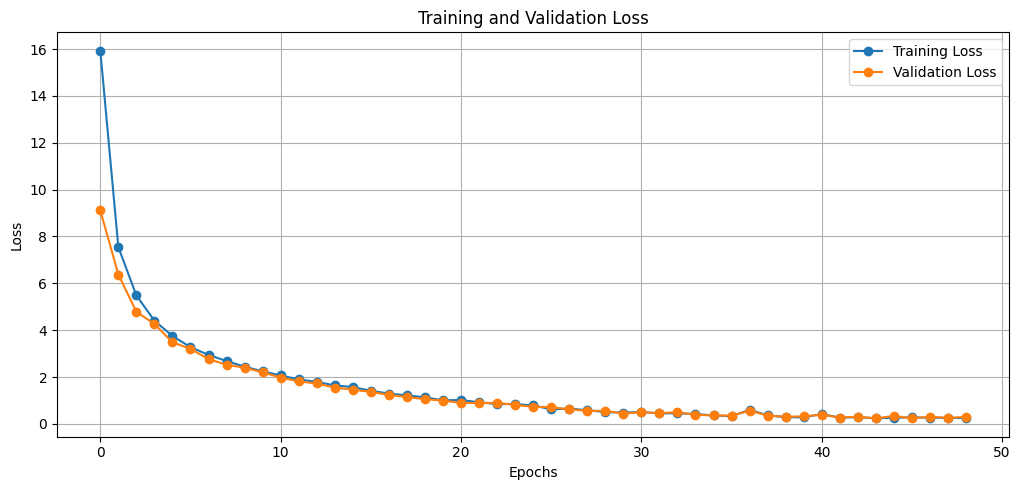

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss',marker='o')
plt.plot(training_history.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

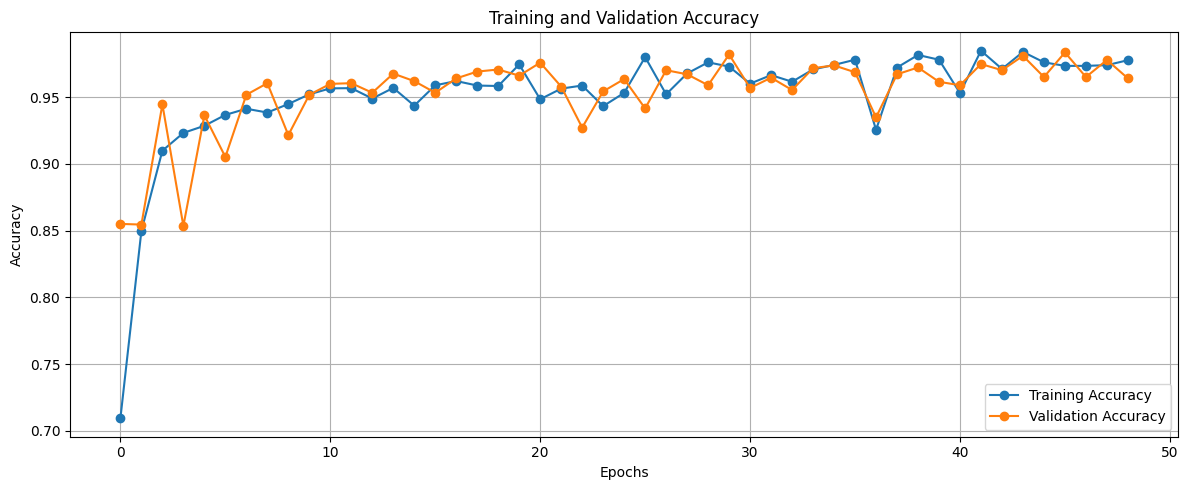

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(training_history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class_names =valid_set.class_names
print("Class Names:", class_names)


for images, labels in valid_set:
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    break

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
Image shape: (32, 224, 224, 3)
Label shape: (32, 4)


In [ ]:
class_names = valid_set.class_names

predictions = []
true_labels = []
for images, labels in valid_set:
    preds = model.predict(images)  # Get probabilities for each class
    predictions.extend(np.argmax(preds, axis=1))  # Get predicted class index
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Get true class index

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Optionally, print the first few predictions with true labels
for i in range(50):
    print(f"Image {i+1}: Predicted - {class_names[predictions[i]]}, True - {class_names[true_labels[i]]}")

# Calculate accuracy or other metrics
accuracy = np.mean(predictions == true_labels)
print(f"Validation Accuracy: {accuracy:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

In [ ]:
from sklearn.metrics import classification_report

# Get class names from the dataset
class_names = test_set.class_names

# Perform predictions on the validation set
predictions = []
true_labels = []
for images, labels in test_set:
    preds = model.predict(images)  # Get probabilities for each class
    predictions.extend(np.argmax(preds, axis=1))  # Get predicted class index
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Get true class index

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Print the first few predictions with true labels
for i in range(400):
    print(f"Image {i+1}: Predicted - {class_names[predictions[i]]}, True - {class_names[true_labels[i]]}")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nTesing 1 Accuracy: {accuracy:.2%}")
precision = precision_score(true_labels, predictions, average='weighted')
print(f"Precision: {precision:.2f}")
recall = recall_score(true_labels, predictions, average='weighted')
print(f"Recall: {recall:.2f}")
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Generate and display the classification report
report = classification_report(
    true_labels,
    predictions,
    target_names=class_names,
    digits=2
)
print("\nClassification Report:\n")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

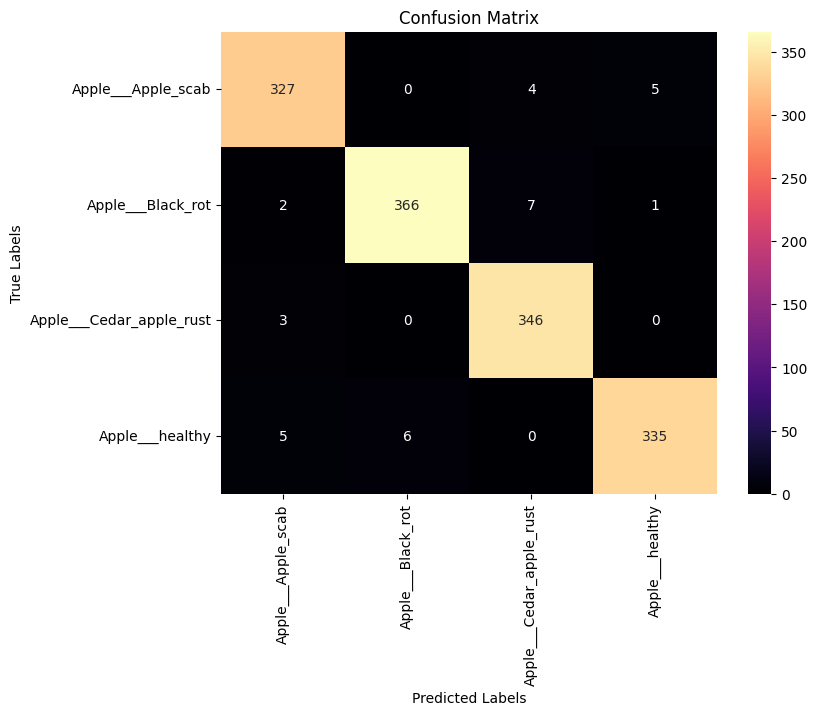

In [ ]:
cm = confusion_matrix(true_labels, predictions, labels=np.arange(len(class_names)))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
test_dir_2 = os.path.join(dataset, 'Testing_bg_removed_2')
test_set_2 = tf.keras.utils.image_dataset_from_directory(
    test_dir_2,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1010 files belonging to 4 classes.


In [ ]:
predictions_2 = []
true_labels_2 = []
for images, labels in test_set_2:
    preds = model.predict(images)  # Get probabilities for each class
    predictions_2.extend(np.argmax(preds, axis=1))  # Get predicted class index
    true_labels_2.extend(np.argmax(labels.numpy(), axis=1))  # Get true class index

# Convert to numpy arrays
predictions_2 = np.array(predictions_2)
true_labels_2 = np.array(true_labels_2)

for i in range(1010):
    print(f"Image {i+1}: Predicted - {class_names[predictions_2[i]]}, True - {class_names[true_labels_2[i]]}")

# Calculate accuracy
accuracy_2 = accuracy_score(true_labels_2, predictions_2)
print(f"\nTesing 2 Accuracy: {accuracy_2:.2%}")
precision_2 = precision_score(true_labels_2, predictions_2, average='weighted')
print(f"Precision: {precision_2:.2f}")
recall_2 = recall_score(true_labels_2, predictions_2, average='weighted')
print(f"Recall: {recall_2:.2f}")
f1_2 = f1_score(true_labels_2, predictions_2, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Generate and display the classification report
report = classification_report(
    true_labels_2,
    predictions_2,
    target_names=class_names,
    digits=2
)
print("\nClassification Report:\n")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

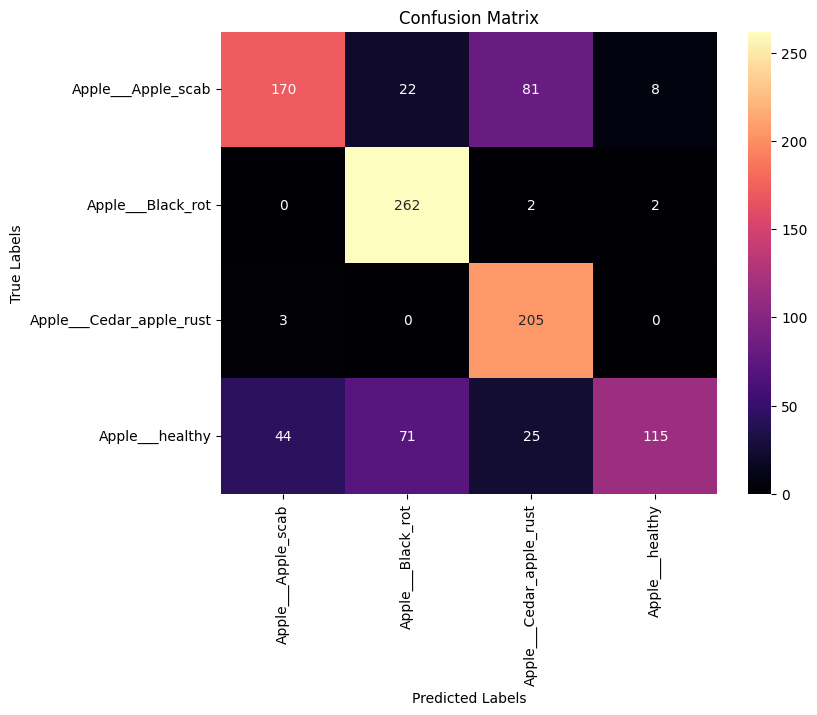

In [ ]:
cm = confusion_matrix(true_labels_2, predictions_2, labels=np.arange(len(class_names)))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
history_dict =training_history.history
with open('/content/drive/MyDrive/Plant_Disease/Apple_Disease_4classes_64_2.json', 'w') as json_file:
    json.dump(history_dict, json_file)

In [ ]:
model.save('/content/drive/MyDrive/Plant_Disease/Apple_Disease_4classes_64_2.keras')

In [ ]:
model.save_weights('/content/drive/MyDrive/Plant_Disease/Apple_Disease_4classes_64_weights_2.weights.h5')